# **PGD Attack** and Binary Input Detector Using MNIST10

## **Projected Gradient Descent (PGD) Attack - Overview**


The Projected Gradient Descent (PGD) attack is a popular method used to generate adversarial examples for neural networks, particularly for tasks like image classification. It belongs to the family of **iterative attacks**, meaning that instead of just perturbing the input once, it repeatedly refines the perturbation to gradually mislead the model. PGD is often considered a more robust attack than the simple Fast Gradient Sign Method (FGSM) because it involves multiple steps, allowing for more powerful adversarial examples.

**Key Concepts:**

* **Adversarial Example:** A modified input that is designed to cause the model to make an incorrect prediction.
* **Adversarial Perturbation:** A small change to the original input that makes the model misclassify it.
* **Projected Gradient Descent (PGD):** An iterative method that modifies the input by applying gradient-based steps and then projects it back to a feasible region to ensure the perturbation is constrained.

**Steps in PGD Attack**

The core idea behind PGD is to iteratively update the input using the **gradient of the loss function** with respect to the input, ensuring that each update stays within a certain bound (usually the $ℓ_{∞}$​-norm).

**1. Initialization:**

PGD starts with an input $x_{0}$​ (the original image) and adds a small random noise to it, creating an initial perturbed input $x_{0}+δ_{0}​$. The perturbation is bounded by a maximum allowed norm (usually the $ℓ∞$​-norm).

**2. Gradient Step:**

In each iteration, the attack computes the gradient of the loss with respect to the input. The model’s loss function is usually a cross-entropy loss for classification tasks. The goal is to maximize this loss to mislead the classifier, so the gradient is computed in the direction that increases the loss.

**3. Update Rule:**

Each iteration updates the perturbation based on the gradient:
$$x_{t+1}=Proj_{B_{(x0,ϵ)}}(x_{t}+α⋅sign(∇_{x}J(x_{t},y)))$$

Where:

- $x_{t}$​ is the perturbed input at the $t-th$ iteration.
- $α$ is the step size or learning rate for each update (determines how big the update should be).
- $∇_{x}J(x_{t},y)$ is the gradient of the loss function $J$ with respect to the input $x$ (i.e., how the model's loss changes as the input changes).
- $sign(∇_{x}J(x_{t},y))$ is the element-wise sign of the gradient, which ensures the perturbation moves in the direction that maximizes the loss.
- $Proj_{B_{(x0,ϵ)}}$​ is the projection operation that ensures the perturbation stays within the allowed perturbation norm. Here, $B_{(x0,ϵ)}$ is the ball of radius $ϵ$ around the original input $x_{0}​$, typically defined using the $ℓ$∞​-norm.

**4. Projection:**

After each update, we project the perturbed input back into a ball of radius $ϵ$ around the original input. This ensures that the adversarial example is not too different from the original input in terms of the allowed perturbation. The projection operator essentially clamps each pixel’s value to lie within the valid range of the image and ensures that the perturbation does not exceed the allowed ϵ-radius.

**5. Repeat:**

Steps 2 to 4 are repeated for a fixed number of iterations $T$, or until the attack succeeds in fooling the model.
Formula Breakdown

Let's break down the formula into its components:
$$x_{t+1}=Proj_{B_{(x0,ϵ)}}(x_{t}+α⋅sign(∇_{x}J(x_{t},y)))$$

- $sign(∇_{x}J(x_{t},y))$: This part calculates the direction of the gradient of the loss with respect to the input $x$. The sign operation ensures that the perturbation only moves in the direction of the steepest increase in the loss function.

- $α⋅sign(∇_{x}J(x_{t},y))$: The step size $α$ controls how large the perturbation should be at each step. This can be adjusted to make the attack stronger or weaker.

- $x_{t}+α⋅sign(∇_{x}J(x_{t},y))$: This updates the perturbed image by adding the gradient-based perturbation to the current image $x_{t}$​.

- $Proj_{B_{(x0,ϵ)}}$: The projection operation ensures that the perturbation does not exceed the allowed $ℓ∞$-norm bound. The adversarial example must remain close to the original input, within a radius $ϵ$, where $ϵ$ is the maximum allowed perturbation.
    - $B(x_{0},ϵ)$ is a ball of radius $ϵ$ centered at $x_{0}$​ in the input space.
    - This projection typically clips the perturbed image values so that they remain within the valid range of pixel values (e.g., [0, 255] for image pixels).

**How PGD Works During the Attack**

1. **Start:** Initialize the perturbed image $x_{0}+δ_{0}$​, where $δ_{0}$​ is a small random perturbation added to the original input $x_{0}$.

2. **Iterative Steps:**
    - For each iteration, compute the gradient of the loss function with respect to the current perturbed image $x_{t}$​, i.e., $∇_{x}J(x_{t},y)$.
    - Update the perturbed image $x_{t}$​ by adding the gradient’s sign, scaled by a step size $α$.
    - Project the updated image back into the $ϵ$-ball around the original image to ensure the perturbation does not exceed the allowable bound.

3. **End:** After a fixed number of iterations or when the attack succeeds in fooling the classifier, stop. The final perturbed image $x_{T}$​ is the adversarial example.

**Strengths of PGD**

* **Stronger Attack:** Since PGD uses multiple iterations, it can generate stronger adversarial examples compared to single-step methods like FGSM.
* **Versatility:** PGD works with various types of loss functions, making it applicable to a wide range of tasks and models.
* **Robustness:** It is often more successful in fooling models, as the iterative refinement allows the attack to find more subtle and effective perturbations.


## **Implementation**

This notebook shows the **Projected Gradient Descent** attack implmentation using the ART library against deep learning models trained on MNIST-10 dataset. The notebook covers the following:

* Load the required libariries
* Load the dataset and inspect the data
* Create a deep learning model
* Train and evaluate the deep learning model on MNIST10 test data
* Create an ART Keras classifier.
* Implement PGD attack using ART
* Create adversarial samples using the PDG attack
* Evaluate the deep leaarning model against the adversarial samples
* Create a detector model to detect adversarial samples
* Train and evaluate the detector model

### Install required Libraries

In [57]:
# Install the Adversarial Robustness Toolbox for creating and evaluating adversarial attacks.
!pip install adversarial-robustness-toolbox

# Install VisualKeras for visualizing model architecture with layer types and connections.
!pip install visualkeras

In [58]:
# Suppress warnings to keep the notebook output clean.
import warnings
warnings.filterwarnings('ignore')

# Import TensorFlow and disable eager execution for compatibility with some ART components.
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

# Import numerical and visualization libraries.
import numpy as np
from matplotlib import pyplot as plt
import os

# Import ART (Adversarial Robustness Toolbox) modules:
# - KerasClassifier wraps Keras models for ART compatibility.
# - ProjectedGradientDescent is an evasion attack method.
# - BinaryInputDetector is used to detect adversarial inputs.
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.detector.evasion import BinaryInputDetector

### Load MNIST dataset

In [59]:
# Load MNIST dataset from TensorFlow's built-in datasets.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to the range [0, 1].
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Get minimum and maximum pixel values (should be 0.0 and 1.0 after normalization).
min_val = x_train.min()
max_val = x_train.max()

# Output dataset shapes and value range for verification.
x_train.shape, y_train.shape, x_test.shape, y_test.shape, min_val, max_val

((60000, 28, 28),
 (60000,),
 (10000, 28, 28),
 (10000,),
 np.float32(0.0),
 np.float32(1.0))

#### Inpect the data


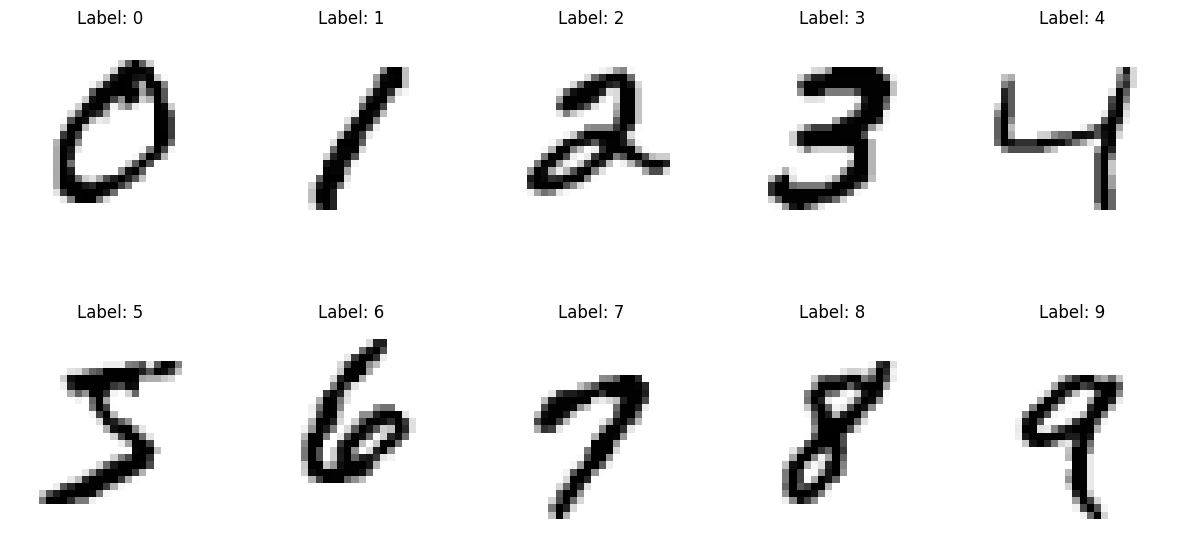

In [60]:
# Plot 10 sample images from the training set with their corresponding labels.
fig, ax = plt.subplots(2, 5, figsize=(15, 7))
ax = ax.flatten()

# Display one example image for each digit label from 0 to 9.
for i in range(10):
    # Get the first image corresponding to label i
    img_idx = np.argwhere(y_train == i)[0][0]
    ax[i].imshow(x_train[img_idx], cmap='gray_r')
    ax[i].set_title(f"Label: {i}", fontsize=12)
    ax[i].axis('off')

#### Reshape and one-hot encode the data

In [61]:
# Number of output classes (digits 0 through 9).
nb_classes = 10

# One-hot encode the labels for training and testing sets.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_classes)

# Expand image dimensions to add a channel axis (from [28, 28] to [28, 28, 1]).
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

## **Model Training**

### **Model Description**

This convolutional neural network (CNN) is designed for image classification tasks. It consists of several layers that progressively extract features from the input images and classify them into one of 10 categories.

1. Input Layer: The model accepts input images of shape (28, 28, 1).
2. Convolutional Layers:
    * First Conv Layer: 32 filters of size (3x3), activated by ReLU, followed by max pooling (2x2).
    * Second Conv Layer: 64 filters of size (3x3), activated by ReLU, followed by max pooling (2x2).
    * Third Conv Layer: 128 filters of size (3x3), activated by ReLU, followed by max pooling (2x2).
3. Flatten Layer: Converts the 2D feature maps to a 1D feature vector.
4. Dense Layer: Fully connected layer with 128 neurons, activated by ReLU, and includes a dropout of 20% to prevent overfitting.
5. Output Layer: 10 neurons with softmax activation to classify the input image into one of the 10 categories.

The model is compiled with the Adam optimizer and uses categorical cross-entropy loss, with accuracy as the performance metric.

In [62]:
# Define a sequential Convolutional Neural Network (CNN) model.
model = tf.keras.models.Sequential([
    # First convolutional block: Conv → ReLU → MaxPooling
    # tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional block
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', strides=1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', strides=1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Flatten the output to feed into dense layers
    tf.keras.layers.Flatten(),

    # Fully connected dense layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout for regularization

    # Output layer with softmax activation for multi-class classification
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### Visualize the CNN Architecture

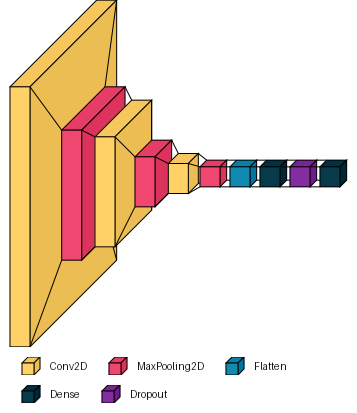

In [63]:
import visualkeras
# Display a layered visual representation of the model architecture.
# 'scale_xy' controls the scaling of the diagram.
# 'legend=True' shows layer types with corresponding color codes.
visualkeras.layered_view(model, scale_xy=10, legend=True)

### Model Summary

In [64]:
# Print a detailed summary of the model architecture,
# including layer types, output shapes, and number of parameters.
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,578 (396.79 KB)

 Trainable params: 101,578 (396.79 KB)

 Non-trainable params: 0 (0.00 B)

### Visualize Model Architecture Diagram

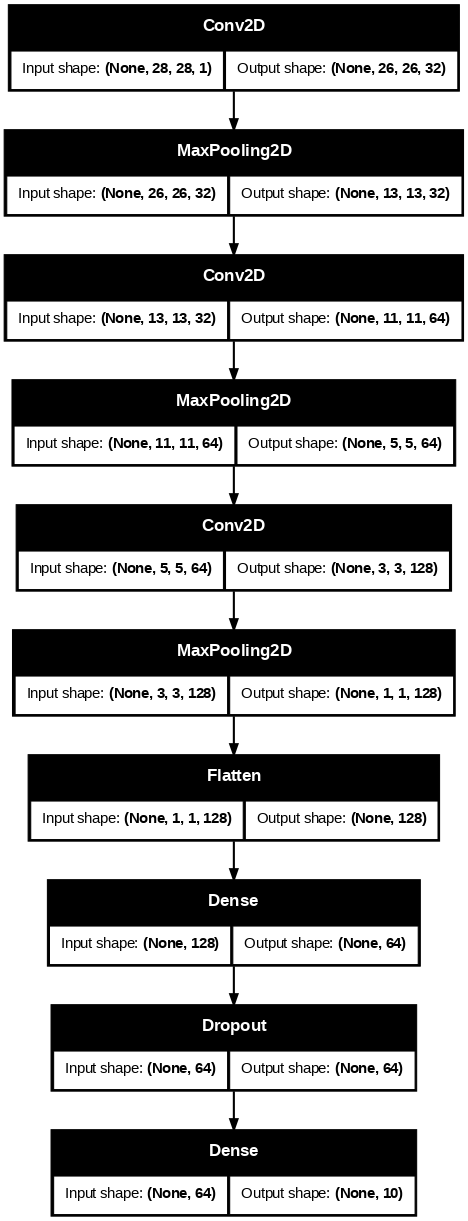

In [65]:
# Generate and display a plot of the model architecture,
# showing each layer’s name and output shape.
tf.keras.utils.plot_model(model, show_shapes=True, dpi = 75)

## Train the CNN Model

In [66]:
# Train the model on the training data for 10 epochs.
# The history object stores training metrics and loss values.
# history = model.fit(x_train, y_train, epochs=10, batch_size=128)

## Load or Save the Trained Model

In [67]:
# If you have trained your own model and want to save it, uncomment and run:
model_path = './mnist10_model.keras'
# model.save(model_path)

# Otherwise, load the pretrained model provided.
# Pretrained model raw link from GitHub
url = 'https://raw.githubusercontent.com/mnazari123/SecAI-Workshop-Fall25/main/Models/General_Models/mnist10_model.keras'

# Download the model only if it doesn't exist
if not os.path.exists(model_path):
    os.system(f"wget {url} -O {model_path}")

# Load the pretrained model
import keras
model = keras.models.load_model(model_path)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,736 (1.16 MB)

 Trainable params: 101,578 (396.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,158 (793.59 KB)

### Evaluate Model Performance on Test Data

In [68]:
# Evaluate the model on the test dataset and get loss and accuracy.
loss_test, accuracy_test = model.evaluate(x_test, y_test)

# Print the test accuracy as a percentage.
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9869 - loss: 0.0708
Accuracy on test data: 98.96%


### Wrap the Keras Model with an ART Classifier

In [69]:
# Create an ART KerasClassifier to enable adversarial robustness tools.
# 'clip_values' defines the input data range for normalization and attack generation.
classifier = KerasClassifier(model=model, clip_values=(min_val, max_val))

# **Projected Gradient Descent (PGD)**

## Overview



> class art.attacks.evasion.ProjectedGradientDescent(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE | OBJECT_DETECTOR_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, decay: float | None = None, max_iter: int = 100, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, random_eps: bool = False, summary_writer: str | bool | SummaryWriter = False, verbose: bool = True)

The Projected Gradient Descent attack is an iterative method in which, after each iteration, the perturbation is projected on an lp-ball of specified radius (in addition to clipping the values of the adversarial sample so that it lies in the permitted data range). This is the attack proposed by Madry et al. for adversarial training.
* Paper link: https://arxiv.org/abs/1706.06083

*\_\_init__(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE | OBJECT_DETECTOR_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, decay: float | None = None, max_iter: int = 100, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, random_eps: bool = False, summary_writer: str | bool | SummaryWriter = False, verbose: bool = True)*

**Create a ProjectedGradientDescent instance.**

    Parameters:
* estimator – An trained estimator.
* norm – The norm of the adversarial perturbation supporting “inf”, np.inf, 1 or 2.
* eps – Maximum perturbation that the attacker can introduce.
* eps_step – Attack step size (input variation) at each iteration.
* random_eps (bool) – When True, epsilon is drawn randomly from truncated normal distribution. The literature suggests this for FGSM based training to generalize across different epsilons. eps_step is modified to preserve the ratio of eps / eps_step. The effectiveness of this method with PGD is untested (https://arxiv.org/pdf/1611.01236.pdf).
* decay – Decay factor for accumulating the velocity vector when using momentum.
* max_iter (int) – The maximum number of iterations.
* targeted (bool) – Indicates whether the attack is targeted (True) or untargeted (False).
* num_random_init (int) – Number of random initialisations within the epsilon ball. For num_random_init=0 starting at the original input.
* batch_size (int) – Size of the batch on which adversarial samples are generated.
* summary_writer – Activate summary writer for TensorBoard. Default is False and deactivated summary writer. If True save runs/CURRENT_DATETIME_HOSTNAME in current directory. If of type str save in path. If of type SummaryWriter apply provided custom summary writer. Use hierarchical folder structure to compare between runs easily. e.g. pass in ‘runs/exp1’, ‘runs/exp2’, etc. for each new experiment to compare across them.
* verbose (bool) – Show progress bars.

    
**generate(x: ndarray, y: ndarray | None = None, \*\*kwargs) → ndarray**
Generate adversarial samples and return them in an array.
    
    
    Return type:
* ndarray
    
    
    Parameters:
* x (ndarray) – An array with the original inputs.
* y – Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape (nb_samples,). Only provide this parameter if you’d like to use true labels when crafting adversarial samples. Otherwise, model predictions are used as labels to avoid the “label leaking” effect (explained in this paper: https://arxiv.org/abs/1611.01236). Default is None.
* mask (np.ndarray) – An array with a mask broadcastable to input x defining where to apply adversarial perturbations. Shape needs to be broadcastable to the shape of x and can also be of the same shape as x. Any features for which the mask is zero will not be adversarially perturbed.


    Returns:
* An array holding the adversarial examples.

    
**set_params(\*\*kwargs) → None**

Take in a dictionary of parameters and apply attack-specific checks before saving them as attributes.

    Parameters:
* kwargs – A dictionary of attack-specific parameters.

    
    property summary_writer
* The summary writer.

Link: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#projected-gradient-descent-pgd



## Create a ART Projected Gradient Descent attack.

In [39]:
# eps – defines the attack step size (input variation). The smaller the eps, the little the attack scale would be.
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.2)

## Generate Adversarial Examples Using PGD Attack

In [40]:
# Reduce test set size to 500 samples for faster adversarial generation and evaluation.
x_test = x_test[:500]
y_test = y_test[:500]

# Generate adversarial examples from the reduced test set using the PGD attack.
# x_test_adv = attack_pgd.generate(x_test)


### Save or Load PGD-Generated Adversarial Test Data

In [70]:
# Option 1: Save your newly generated adversarial test data (uncomment to use).
pgd_data_path = 'pgd_poison_data_MNIST10_test_S500.npz'
# np.savez(pgd_data_path,
#          x_test_adv=x_test_adv, y_test_adv=y_test)

# Option 2: Load previously saved adversarial test data (recommended for reuse or quick experiments).
# Download the data file from GitHub raw URL
poison_data = 'https://github.com/mnazari123/SecAI-Workshop-Fall25/raw/main/Datasets/SecAI_Workshop01_Datasets/SecAI_Workshop01_PGD_datasests/pgd_poison_data_MNIST10_test_S500.npz'

# Download the model only if it doesn't exist
if not os.path.exists(pgd_data_path):
    os.system(f"wget {poison_data} -O {pgd_data_path}")

x_test_data = np.load(pgd_data_path)
x_test_adv, y_test = x_test_data['x_test_adv'], x_test_data['y_test_adv']
x_test_adv.shape, y_test.shape

((500, 28, 28, 1), (500, 10))

## Visualize Adversarial Examples and Their Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


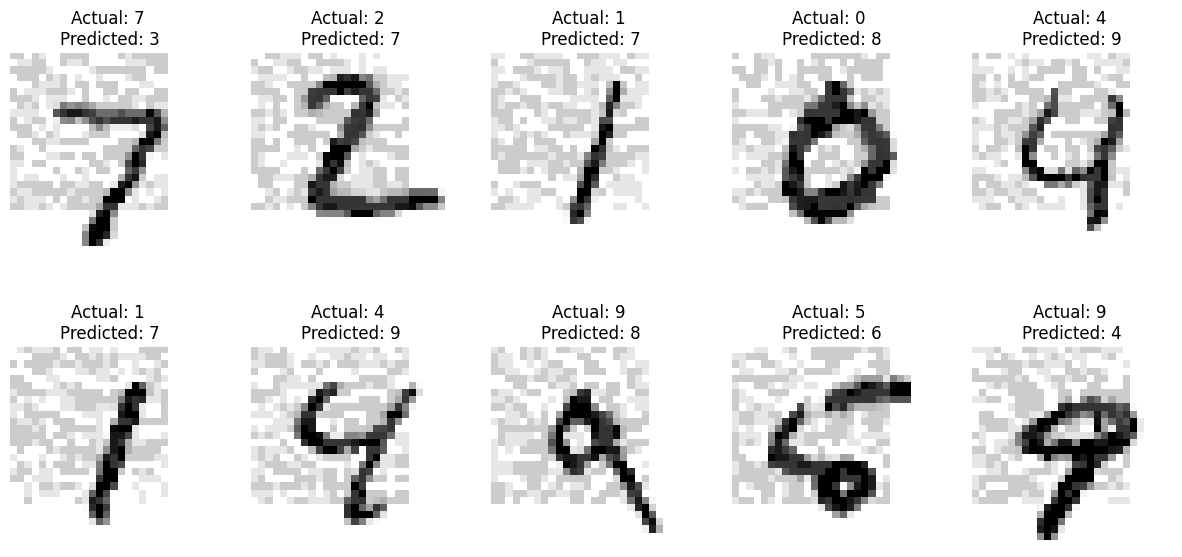

In [42]:
# Display the first 10 adversarial examples along with their actual and predicted labels.
fig, ax = plt.subplots(2, 5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
    # Display the adversarial image.
    ax[i].imshow(image.squeeze(), cmap='gray_r')

    # Show actual and predicted labels.
    prediction = model.predict(np.expand_dims(image, axis=0)).argmax()
    ax[i].set_title(f"Actual: {label.argmax()} \nPredicted: {prediction}", fontsize=12)
    ax[i].axis('off')


## Evaluate the Model on Adversarial Test Data

In [44]:
# Evaluate model performance on adversarial examples.
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)

# Calculate the average perturbation introduced by the adversarial attack.
perturbation = np.mean(np.abs(x_test_adv - x_test))

# Print evaluation results.
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0167 - loss: 13.8637
Accuracy on adversarial test data: 2.20%
Average perturbation: 0.07


# Prepare Training Data for Adversarial Sample Detector

In [ ]:
# Generate new adversarial examples from a subset of the training data using PGD.
x_train_adv = attack_pgd.generate(x_train[:500])
nb_train = x_train[:500].shape[0]

# Combine clean and adversarial samples to create a binary classification dataset for detection.
x_train_detector = np.concatenate((x_train[:500], x_train_adv), axis=0)

# Create labels: [1, 0] for clean samples, [0, 1] for adversarial samples.
y_train_detector = np.concatenate((
    np.array([[1, 0]] * nb_train),  # Clean
    np.array([[0, 1]] * nb_train)   # Adversarial
), axis=0)

##Save or Load Adversarial Detector Training Data

In [45]:
# Option 1: Save generated clean and adversarial samples for training the detector.
# np.savez('./pgd_poison_data_MNIST10_train_S1000.npz',
#          x_train_detector=x_train_detector, y_train_detector=y_train_detector)

# Option 2: Load pre-saved detector training data from GitHub
url = "https://github.com/mnazari123/SecAI-Workshop-Fall25/raw/main/Datasets/SecAI_Workshop01_Datasets/SecAI_Workshop01_PGD_datasests/pgd_poison_data_MNIST10_train_S1000.npz"
local_file = "pgd_poison_data_MNIST10_train_S1000.npz"

# Download once if not already present
if not os.path.exists(local_file):
    os.system(f"wget {url} -O {local_file}")

# Load the .npz dataset
detector_data = np.load(local_file, allow_pickle=True)
x_train_detector, y_train_detector = detector_data['x_train_detector'], detector_data['y_train_detector']

# Verify the shape of loaded data
print(x_train_detector.shape, y_train_detector.shape)

(1000, 28, 28, 1) (1000, 2)


## Build a similar CNN architecture model for detecting Adversarial Inputs

In [46]:
# Define a CNN model to detect adversarial vs. clean images (binary classification).
detector_model = tf.keras.models.Sequential([
    # First convolutional block
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional block
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', strides=1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', strides=1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Classification head
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')  # Two output classes: [clean, adversarial]
])

# Compile the detector model with Adam optimizer and categorical crossentropy loss.
detector_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train the Adversarial Detector Model

In [50]:
# Train the adversarial detector model for 3 epochs.
# Since the goal is to distinguish between clean and adversarial inputs,
# a few epochs (e.g., 3) are typically sufficient to learn this binary classification task.
history = detector_model.fit(x_train_detector, y_train_detector, epochs=10)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6779 - loss: 0.5778
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9996 - loss: 0.0081
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 7.1347e-04
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 1.0000 - loss: 3.1820e-04
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 1.0000 - loss: 1.1856e-04
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 1.0000 - loss: 2.3392e-04
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 1.0000 - loss: 1.4810e-04
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 5.9281e-05
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 6.6766e-05
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 1.0000 - loss: 4.1214e-05


In [47]:
# Define path to save/load the detector model
detector_model_path = './PGD_detector_model_mnist10.keras'
# detector_model.save(detector_model_path)

# Load the pre-trained detector model from the specified path
# Pretrained model raw link from GitHub
url = 'https://raw.githubusercontent.com/mnazari123/SecAI-Workshop-Fall25/main/Models/SecAI_Workshop01_Models/PGD_detector_model_mnist10.keras'

# Download the model only if it doesn't exist
if not os.path.exists(detector_model_path):
    os.system(f"wget {url} -O {detector_model_path}")

# Load the pretrained model
detector = tf.keras.models.load_model(detector_model_path)

# Display model summary
detector.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,328 (1.25 MB)

 Trainable params: 109,442 (427.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 218,886 (855.03 KB)

## Prepare test samples for the detector model

In [51]:
# Get the number of original test samples
nb_test = x_test.shape[0]

# Combine clean and adversarial test images into one array
x_test_detector = np.concatenate((x_test, x_test_adv), axis=0)

# Create corresponding labels: [1, 0] for clean, [0, 1] for adversarial
y_test_detector = np.concatenate((np.array([[1, 0]] * nb_test),
                                  np.array([[0, 1]] * nb_test)), axis=0)


### Evaluat the result

In [52]:
# --- Evaluate the detector model on combined test data ---

# Evaluate the model's performance on clean + adversarial samples
loss_test, accuracy_test = detector_model.evaluate(x_test_detector, y_test_detector)

# Print the accuracy as a percentage
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9961 - loss: 0.0046
Accuracy on test data: 99.90%


## Wrap detector model for adversarial detection

In [53]:
# Wrap the Keras detector model with ART's KerasClassifier
detector_classifier = KerasClassifier(clip_values=(0.0, 0.1), model=detector_model, use_logits=False)

# Create a BinaryInputDetector using the wrapped classifier
detector = BinaryInputDetector(detector_classifier)


## Train the BinaryInputDetector

In [54]:
## Train the BinaryInputDetector

# Train the detector on labeled clean and adversarial training data
detector.fit(x_train_detector, y_train_detector, nb_epochs=3, batch_size=32)

## Evaluating the detector

In [55]:
# Apply the detector to the adversarial test data
_, is_adversarial = detector.detect(x_test_adv)

# Count how many adversarial samples were flagged
flag_adv = np.sum(is_adversarial)

# Display detection results
print("Adversarial test data (first 500 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(500 - flag_adv))

Adversarial test data (first 500 images):
Flagged: 500
Not flagged: 0


## Evaluating the detector on clean (non-adversarial) data

In [56]:
# Apply the detector to the first 500 clean test samples
_, is_adversarial = detector.detect(x_test[:500])

# Count how many clean samples were incorrectly flagged as adversarial
flag_original = np.sum(is_adversarial)

# Display detection results
print("Original test data (first 500 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(500 - flag_original))


Original test data (first 500 images):
Flagged: 1
Not flagged: 499


## Evaluate the detector across different attack strengths (eps values)

In [ ]:
# Note: Detector was trained with adversarial samples generated using eps = 0.2

eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_flag_adv = []      # Number of adversarial examples flagged by the detector
nb_missclass = []     # Number of adversarial examples that fooled the classifier

for eps in eps_range:
    # Update PGD attack with current epsilon
    attack_pgd.set_params(**{'eps': eps})

    # Generate adversarial examples for current eps
    x_test_adv = attack_pgd.generate(x_test[:100])

    # Count how many were flagged by the detector
    nb_flag_adv.append(np.sum(detector.detect(x_test_adv)[1]))

    # Count how many were misclassified by the classifier
    nb_missclass.append(
        np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))
    )

# Add clean data evaluation (eps=0) to the results
eps_range = [0] + eps_range
nb_flag_adv = [flag_original] + nb_flag_adv  # flag_original from clean data detection
nb_missclass = [2] + nb_missclass            # 2 misclassifications in clean test subset

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

## Plot detector performance vs. classifier errors for varying attack strengths

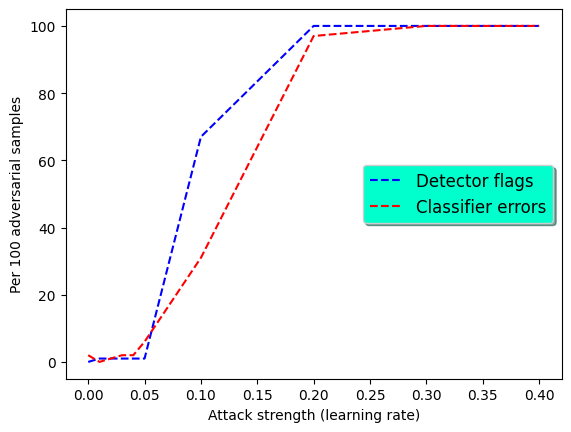

In [ ]:
fig, ax = plt.subplots()

# Plot number of adversarial samples flagged by the detector
ax.plot(np.array(eps_range)[:10], np.array(nb_flag_adv)[:10], 'b--', label='Detector flags')

# Plot number of adversarial samples misclassified by the classifier
ax.plot(np.array(eps_range)[:10], np.array(nb_missclass)[:10], 'r--', label='Classifier errors')

# Customize legend
legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

# Add axis labels
plt.xlabel('Attack strength (learning rate)')
plt.ylabel('Per 100 adversarial samples')

# Display the plot
plt.show()


## **Summary of PGD Attack Implementation on MNIST10**


Overview

I have implemented the Projected Gradient Descent (PGD) attack on the MNIST10 dataset, which consists of handwritten digits from 0 to 9. The PGD attack is a widely-used adversarial attack method designed to test the robustness of machine learning models, particularly deep neural networks, against adversarial examples. This summary aims to explain the workings of the PGD attack, its implementation, and the impact of the perturbation magnitude (epsilon, ε) on the effectiveness of the attack.

#### **PGD Attack Mechanism**

The PGD attack is an iterative method that generates adversarial examples by applying small perturbations to the input data. The goal is to make these perturbed inputs cause the model to produce incorrect outputs while remaining visually similar to the original inputs. The key steps of the PGD attack are as follows:

1. **Initialization**: Start with an original input sample xx from the dataset.
2. **Perturbation**: Add a small, carefully chosen perturbation ηη to the input xx such that the new input $x=x+ηx$ misleads the model. The perturbation is bounded by a parameter $ϵ$ (epsilon), which controls the maximum allowed distortion.
3. **Iterative Optimization**: Apply gradient ascent iteratively to maximize the model's loss with respect to the input $x′$. After each iteration, project $x′$ back into the $ϵ$-ball around xx to ensure the perturbation remains within the specified bounds.

Mathematically, the PGD attack can be formulated as:
$$xt+1′=clipx,ϵ(xt′+α⋅sign(∇xL(θ,xt′,y)))$$
where $clipx,ϵ​$ projects the perturbed input back into the $ϵ$-ball around $x$, $α$ is the step size, $∇xL(θ,xt′,y)$ is the gradient of the loss with respect to the input, and LL is the loss function.

#### **Impact of Epsilon (ε)**

The parameter $ϵ$ plays a critical role in determining the effectiveness of the PGD attack. It defines the maximum amount of perturbation allowed for each input. The impact of $ϵ$ can be summarized as follows:

* Small $ϵ$: When ϵϵ is small, the perturbations are minimal, and the adversarial examples remain very close to the original inputs. This might lead to limited success in fooling the model, especially if the model is robust to small perturbations.
* Large $ϵ$: As $ϵ$ increases, the perturbations become more noticeable, potentially making the adversarial examples more effective in causing misclassification. However, very large ϵϵ values can result in perturbed inputs that no longer resemble the original data, which may be unrealistic in practical scenarios.

The trade-off is to find an optimal $ϵ$ that balances the attack's success rate and the visual similarity of the adversarial examples to the original inputs.

#### **Results and Observations**

In the implementation on the MNIST10 dataset, varying ϵϵ values demonstrated the following:

* Low $ϵ$ (e.g., 0.1): The model's accuracy drops slightly, indicating that minor perturbations are not significantly affecting the model's predictions.
* Moderate $ϵ$ (e.g., 0.3): The model's accuracy decreases more substantially, suggesting that the adversarial examples are effectively misleading the model.
* High $ϵ$ (e.g., 0.5): The model's accuracy drops drastically, but the perturbations become more visible, potentially compromising the adversarial example's subtlety.

#### **Conclusion**

The PGD attack on MNIST10 illustrates the vulnerability of neural networks to adversarial examples and highlights the importance of robust model training. The choice of ϵϵ is crucial, as it influences both the effectiveness of the attack and the perceptual similarity of the adversarial examples to the original inputs. By experimenting with different ϵϵ values, one can understand the trade-offs involved and work towards developing more resilient machine learning models.